# Community Deception

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Pytorch Geometric

If we are on Kaggle we need to run the following cells to install Pytorch Geometric

In [2]:
import torch
import os

print(torch.__version__)
os.environ["TORCH"] = torch.__version__

print(torch.version.cuda)
os.environ["CUDA"] = "cu118"

2.0.1+cu118
11.8


In [3]:
! pip install torch_geometric
# ! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
! pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-${TORCH}.html
! pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=a49ad478763435f863cfef3a8741c0e7995bad13fb824188f21a4911142a9fed
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric
Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 25.5 MB/s eta 0:00:00


After the libraries installation, restart the runtime and start executing the cells below

## Import Libraries

In [4]:
# Import torch and os another time to reset the colab enviroment after PyG installation
import torch
import os

# Typing
from typing import List, Tuple
from collections import Counter

# Deep Learning
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import scipy

# Graph
import networkx as nx
import igraph as ig

# Misc
from enum import Enum
import math
import random
import json

# Plot
import matplotlib.pyplot as plt
plt.style.use('default')


## Utils

In [5]:
class FilePaths(Enum):
    """Class to store file paths for data and models"""
    # ° Local
    # DATASETS_DIR = 'dataset/data'
    # LOG_DIR    = 'src/logs/'
    # ° Kaggle
    # DATASETS_DIR = '/kaggle/input/network-community'
    # LOG_DIR    = 'logs/'
    # ° Google Colab
    DATASETS_DIR = "/content/drive/MyDrive/Sapienza/Tesi/Datasets"
    LOG_DIR = "/content/drive/MyDrive/Sapienza/Tesi/Logs/"

    # Dataset file paths
    KAR = DATASETS_DIR + '/kar.mtx'
    DOL = DATASETS_DIR + '/dol.mtx'
    MAD = DATASETS_DIR + '/mad.mtx'
    LESM = DATASETS_DIR + '/lesm.mtx'
    POLB = DATASETS_DIR + '/polb.mtx'
    WORDS = DATASETS_DIR + '/words.mtx'
    ERDOS = DATASETS_DIR + '/erdos.mtx'
    POW = DATASETS_DIR + '/pow.mtx'
    FB_75 = DATASETS_DIR + '/fb-75.mtx'
    DBLP = DATASETS_DIR + '/dblp.mtx'
    ASTR = DATASETS_DIR + '/astr.mtx'
    AMZ = DATASETS_DIR + '/amz.mtx'
    YOU = DATASETS_DIR + '/you.mtx'
    ORK = DATASETS_DIR + '/ork.mtx'


class HyperParams(Enum):
    """ Hyperparameters for the model."""

    """ Graph Encoder Parameters """""
    G_IN_SIZE = 64
    G_HIDDEN_SIZE_1 = 128
    G_HIDDEN_SIZE_2 = 64
    G_EMBEDDING_SIZE = 32

    """ Agent Parameters"""
    HIDDEN_SIZE_1 = 64
    HIDDEN_SIZE_2 = 128
    ACTION_STD = 0.5
    EPS_CLIP = 0.2
    LR = 0.0003
    GAMMA = 0.99

    """ Training Parameters """
    # Number of episodes to collect experience
    MAX_EPISODES = 200          # 15000
    # Maximum number of time steps per episode
    MAX_TIMESTEPS = 10  # ! Unused, I set it to the double of the edge budget
    # Update the policy after N timesteps
    UPDATE_TIMESTEP = 100  # ! Unused, I set it to 10 times the edge budget
    # Update policy for K epochs
    K_EPOCHS = 20
    # Print info about the model after N episodes
    LOG_INTERVAL = 20
    # Exit if the average reward is greater than this value
    SOLVED_REWARD = 0.7
    # Save model after N episodes
    SAVE_MODEL = int(MAX_EPISODES / 10)
    # Use a random seed
    RANDOM_SEED = 42

    """Hyperparameters for the Environment"""
    BETA = 30  # Numeber of possible action with BETA=30, is 30% of the edges
    DEBUG = False
    WEIGHT = 0.8


class DetectionAlgorithms(Enum):
    """
    Enum class for the detection algorithms
    """
    LOUV = "louvain"
    WALK = "walktrap"
    GRE = "greedy"
    INF = "infomap"
    LAB = "label_propagation"
    EIG = "eigenvector"
    BTW = "edge_betweenness"
    SPIN = "spinglass"
    OPT = "optimal"
    SCD = "scalable_community_detection"


class Utils:
    """Class to store utility functions"""

    @staticmethod
    def get_device_placement():
        """Get device placement, CPU or GPU"""
        return os.getenv("RELNET_DEVICE_PLACEMENT", "CPU")

    @staticmethod
    def import_mtx_graph(file_path: str) -> nx.Graph:
        """
        Import a graph from a .mtx file

        Parameters
        ----------
        file_path : str
            File path of the .mtx file

        Returns
        -------
        nx.Graph
            Graph imported from the .mtx file
        """
        try:
            graph_matrix = scipy.io.mmread(file_path)
            graph = nx.Graph(graph_matrix)
            for node in graph.nodes:
                # graph.nodes[node]['name'] = node
                graph.nodes[node]['num_neighbors'] = len(
                    list(graph.neighbors(node)))
            return graph
        except Exception as exception:
            print("Error: ", exception)
            return None
    @staticmethod
    def check_dir(path: str):
        """
        Check if the directory exists, if not create it.

        Parameters
        ----------
        path : str
            Path to the directory
        """
        if not os.path.exists(path):
            os.makedirs(path)

    @staticmethod
    def plot_avg_reward(
            log_reward: List[float],
            log_timesteps: List[int],
            log_loss: List[float],
            env_name: str,
            detection_algorithm: str,
            file_path: str = FilePaths.LOG_DIR.value):
        """
        Plot the average reward and the time steps of the episodes in the same
        plot, using matplotlib, where the average reward is the blue line and
        the episode length are the orange line, and the loss in a different
        image.

        Parameters
        ----------
        log_reward : List[float]
            Average reward for each episode
        log_timesteps : List[int]
            Time steps for each episode
        log_loss : List[float]
            Loss for each episode
        env_name : str
            Environment name
        detection_algorithm : str
            Detection algorithm used
        file_path : str, optional
            Path to save the plot, by default "src/logs/"
        """
        _, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Average Reward', color=color)
        ax1.plot(log_reward, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:orange'
        ax2.set_ylabel('Time Steps', color=color)
        ax2.plot(log_timesteps, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title(f"Training {env_name}")
        plt.savefig(
            f"{file_path}{env_name}_{detection_algorithm}_training_reward.png")
        plt.show()

        _, ax1 = plt.subplots()
        multiplier = int(HyperParams.UPDATE_TIMESTEP.value/HyperParams.MAX_TIMESTEPS.value)
        color = 'tab:green'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot([int(i * multiplier) for i in range(len(log_loss))], log_loss, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        plt.title(f"Training {env_name}")
        plt.savefig(
            f"{file_path}{env_name}_{detection_algorithm}_training_loss.png")
        plt.show()

    @staticmethod
    def write_results_to_json(
            log_reward: List[float],
            log_length: List[int],
            log_loss: List[float],
            hyperparameters: dict,
            env_name: str,
            detection_algorithm: str,
            file_path: str = FilePaths.LOG_DIR.value):
        """
        Write the episodes_avg_reward, episode_length, and hyperparameters to a JSON file.

        Parameters
        ----------
        log_reward : List[float]
            List of average rewards for each episode
        log_length : List[int]
            List of episode lengths
        log_loss : List[float]
            List of losses for each episode
        hyperparameters : dict
            Dictionary of hyperparameters used in the training process
        env_name : str
            Environment name
        detection_algorithm : str
            Detection algorithm used
        file_path : str
            Path to the output JSON file
        """
        data = {
            "episodes_avg_reward": log_reward,
            "episode_avg_length": log_length,
            "episode_avg_loss": log_loss,
            "hyperparameters": hyperparameters
        }
        file_name = f"{file_path}{env_name}_{detection_algorithm}_results.json"
        with open(file_name, "w") as f:
            json.dump(data, f, indent=4)


## Community Algorithms

### Communities Detection

In [6]:

class DetectionAlgorithm(object):
    """Class for the community detection algorithms"""

    def __init__(self, alg_name: str) -> None:
        """
        Initialize the DetectionAlgorithm object

        Parameters
        ----------
        alg_name : str
            The name of the algorithm
        """
        self.alg_name = alg_name
        self.ig_graph = None

    def networkx_to_igraph(self, graph: nx.Graph) -> ig.Graph:
        """
        Convert NetworkX graph to iGraph graph, in this way we can use
        iGraph's community detection algorithms

        Parameters
        ----------
        graph : nx.Graph
            The graph to be converted

        Returns
        ----------
        ig.Graph
            The converted graph
        """
        self.ig_graph = ig.Graph.from_networkx(graph)
        return self.ig_graph

    def compute_community(self, graph: nx.Graph, args: dict = None) -> List[List[int]]:
        """
        Compute the community detection algorithm

        Parameters
        ----------
        graph : nx.Graph
            The graph to be computed
        args : dict
            The arguments for the algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        # Transform the graph to igraph
        graph = self.networkx_to_igraph(graph)

        # Rename DetectionAlgorithms Enum to da for convenience
        da = DetectionAlgorithms
        # Choose the algorithm
        if self.alg_name == da.LOUV.value:
            return self.compute_louv(graph, args)
        elif self.alg_name == da.WALK.value:
            return self.compute_walk(graph, args)
        elif self.alg_name == da.GRE.value:
            return self.compute_gre(graph, args)
        elif self.alg_name == da.INF.value:
            return self.compute_inf(graph, args)
        elif self.alg_name == da.LAB.value:
            return self.compute_lab(graph, args)
        elif self.alg_name == da.EIG.value:
            return self.compute_eig(graph, args)
        elif self.alg_name == da.BTW.value:
            return self.compute_btw(graph, args)
        elif self.alg_name == da.SPIN.value:
            return self.compute_spin(graph, args)
        elif self.alg_name == da.OPT.value:
            return self.compute_opt(graph, args)
        elif self.alg_name == da.SCD.value:
            return self.compute_scd(graph)
        else:
            raise ValueError('Invalid algorithm name')

    def vertexcluster_to_list(self, cluster: ig.VertexClustering) -> List[List[int]]:
        """
        Convert iGraph.VertexClustering object to list of list of vertices in each cluster

        Parameters
        ----------
        cluster : ig.VertexClustering
            cluster from iGraph community detection algorithm

        Returns
        -------
        List[List[int]]
            list of list of vertices in each cluster
        """
        return [c for c in cluster]

    def plot_graph(self) -> plt:
        """Plot the graph using iGraph

        Returns
        ---------
        plot: plt
            The plot of the graph

        """
        # fig, ax = plt.subplots(figsize=(10, 10))
        plot = ig.plot(
            self.ig_graph,
            mark_groups=True,
            vertex_size=20,
            edge_color='black',
            vertex_label=[v.index for v in self.ig_graph.vs],
            bbox=(0, 0, 500, 500),
            # target=ax,
        )
        return plot

    def compute_louv(self, graph: ig.Graph, args_louv: dict) -> List[List[int]]:
        """
        Compute the Louvain community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_louv : dict
            The arguments for the Louvain algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_louv is None:
            louv = graph.community_leiden()
        else:
            louv = graph.community_leiden(**args_louv)
        return self.vertexcluster_to_list(louv)

    def compute_walk(self, graph: ig.Graph, args_walk: dict) -> List[List[int]]:
        """
        Compute the Walktrap community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_walk : dict
            The arguments for the Walktrap algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_walk is None:
            walk = graph.community_walktrap()
        else:
            walk = graph.community_walktrap(**args_walk)
        # Need to be converted to VertexClustering object
        return self.vertexcluster_to_list(walk.as_clustering())

    def compute_gre(self, graph: ig.Graph, args_gre: dict) -> List[List[int]]:
        """
        Compute the Greedy community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_greed : dict
            The arguments for the Greedy algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_gre is None:
            greed = graph.community_fastgreedy()
        else:
            greed = graph.community_fastgreedy(**args_gre)
        # Need to be converted to VertexClustering object
        return self.vertexcluster_to_list(greed.as_clustering())

    def compute_inf(self, graph: ig.Graph, args_infomap: dict) -> List[List[int]]:
        """
        Compute the Infomap community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_infomap : dict
            The arguments for the Infomap algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_infomap is None:
            infomap = graph.community_infomap()
        else:
            infomap = graph.community_infomap(**args_infomap)
        return self.vertexcluster_to_list(infomap)

    def compute_lab(self, graph: ig.Graph, args_lab: dict) -> List[List[int]]:
        """
        Compute the Label Propagation community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_lab : dict
            The arguments for the Label Propagation algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_lab is None:
            lab = graph.community_label_propagation()
        else:
            lab = graph.community_label_propagation(**args_lab)
        return self.vertexcluster_to_list(lab)

    def compute_eig(self, graph: ig.Graph, args_eig: dict) -> List[List[int]]:
        """
        Compute the Eigenvector community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_eig : dict
            The arguments for the Eigenvector algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_eig is None:
            eig = graph.community_leading_eigenvector()
        else:
            eig = graph.community_leading_eigenvector(**args_eig)
        return self.vertexcluster_to_list(eig)

    def compute_btw(self, graph: ig.Graph, args_btw: dict) -> List[List[int]]:
        """
        Compute the Edge Betweenness community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_btw : dict
            The arguments for the Betweenness algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if btw is None:
            btw = graph.community_edge_betweenness()
        else:
            btw = graph.community_edge_betweenness(**args_btw)
        # Need to be converted to VertexClustering object
        return self.vertexcluster_to_list(btw.as_clustering())

    def compute_spin(self, graph: ig.Graph, args_spin: dict) -> List[List[int]]:
        """
        Compute the Spin Glass community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_spin : dict
            The arguments for the Spin Glass algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_spin is None:
            spin = graph.community_spinglass()
        else:
            spin = graph.community_spinglass(**args_spin)
        return self.vertexcluster_to_list(spin)

    def compute_opt(self, graph: ig.Graph, args_opt: dict) -> List[List[int]]:
        """
        Compute the Optimal community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered
        args_opt : dict
            The arguments for the Optimal algorithm

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        if args_opt is None:
            opt = graph.community_optimal_modularity()
        else:
            opt = graph.community_optimal_modularity(**args_opt)
        return self.vertexcluster_to_list(opt)

    def compute_scd(self, graph: ig.Graph) -> List[List[int]]:
        """
        Compute the Surprise community detection algorithm

        Parameters
        ----------
        graph : ig.Graph
            The graph to be clustered

        Returns
        ----------
        List[List[int]]
            list of list of vertices in each cluster
        """
        # Write the graph to a text file
        self.write_graph_to_file(graph, "output.txt")
        # Execute SCD algorithm from the git submodule
        os.system("./../src/SCD/build/scd -f output.txt")
        result_list = self.read_data_from_file('communities.dat')
        return result_list

    @staticmethod
    def write_graph_to_file(graph: ig.Graph, file_path: str) -> None:
        """
        Write the graph to a text file, where each line is an
        edge in the graph.

        Parameters
        ----------
        graph : ig.Graph
            Graph object to write to file
        file_path : str
            file path of the output file
        """
        with open(file_path, 'w', encoding='utf-8') as file:
            for edge in graph.get_edgelist():
                # To ensure we don't duplicate edges (x, y) and (y, x)
                if edge[0] < edge[1]:
                    file.write(f"{edge[0]} {edge[1]}\n")

    @staticmethod
    def read_data_from_file(file_path: str) -> List[List[int]]:
        """
        Read data from file and return a list of lists, where each row list of
        nodes is a community.

        Parameters
        ----------
        file_path : str
            File path to the data file.

        Returns
        -------
        List[List[int]]
            List of lists, where each row list of nodes is a community.
        """
        data_list = []
        with open(file_path, 'r', encoding='utf-8') as file:
            for line in file:
                numbers = [int(num) for num in line.strip().split()]
                data_list.append(numbers)
        return data_list

### Deception Score

In [7]:

class DeceptionScore(object):
    """Deception score of a community detection algorithm."""
    def __init__(self, community_target: List[int]) -> None:
        self.community_target = community_target

    @staticmethod
    def recall(g_i: List[int], community_target: List[int]) -> float:
        """Calculate recall score of a community g_i

        Parameters
        ----------
        g_i : List[int]
            Community found by a community detection algorithm.

        Returns
        -------
        float
            Recall score of g_i.
        """
        # Number of members in g_i that are also in our community
        members_in_g_i = len(set(community_target) & set(g_i))
        return members_in_g_i / len(community_target)

    @staticmethod
    def precision(g_i: List[int], community_target: List[int]) -> float:
        """Calculate precision score of a community g_i

        Parameters
        ----------
        g_i : List[int]
            Community found by a community detection algorithm.

        Returns
        -------
        float
            Precision score of g_i.
        """
        # Number of members in G_i that are also in our community
        members_in_g_i = len(set(community_target) & set(g_i))
        return members_in_g_i / len(g_i)

    def compute_deception_score(
            self,
            community_structure: List[List[int]],
            connected_components: int) -> float:
        """Calculate deception score of a community detection algorithm.

        Parameters
        ----------
        community_structure : List(List(int))
            Community structure found by a community detection algorithm.
        connected_components : int
            Number of connected components in the graph.

        Returns
        -------
        deception_score : float
            Deception score of a community detection algorithm.
        """
        # Number of intersecting nodes between the community structure and community target
        n_intersecting_nodes = [g_i for g_i in community_structure if len(
            set(self.community_target) & set(g_i)) > 0]

        recall = max([self.recall(g_i, self.community_target) for g_i in community_structure])
        precision = sum([self.precision(g_i, self.community_target) for g_i in n_intersecting_nodes])

        # Ideal situation occurs when each member of the community target is
        # placed in a different community and the value of the maximum recall
        # is lower possible.
        community_spread = 1 - (connected_components - 1) / (len(self.community_target) - 1)

        # Ideal situation occurs when each member of the community structure
        # contains little percentage of the community target.
        community_hiding = 0.5 * (1 - recall) + 0.5 * (1 - precision / len(n_intersecting_nodes))

        # Deception score is the product of community spread and community hiding.
        deception_score = community_spread * community_hiding
        return deception_score

### Normalized Mutual Information Score

In [8]:

class NormalizedMutualInformation(object):
    @staticmethod
    def calculate_confusion_matrix(
            communities_old: List[List[int]],
            communities_new: List[List[int]]) -> Counter:
        """
        Calculate the confusion matrix between two sets of communities.
        Where the element (i, j) of the confusion matrix is the number of shared
        members between an initially detected community C_i and the community
        C_j after deception.

        Parameters
        ----------
        communities_old : List[List[int]]
            Communities before deception
        communities_new : List[List[int]]
            Communities after deception

        Returns
        -------
        confusion_matrix : Counter
            Confusion matrix
        """
        confusion_matrix = Counter()
        #° Avoid to process the same community twice
        #BUG ZeroDivisionError if we use this optimization
        #BUG processed_new = set()
        for i, old in enumerate(communities_old):
            for j, new in enumerate(communities_new):
                #BUG if j not in processed_new:
                intersection = len(set(old) & set(new))
                confusion_matrix[(i, j)] = intersection
                #BUG    if intersection > 0:
                #BUG        processed_new.add(j)
        return confusion_matrix

    @staticmethod
    def calculate_sums(confusion_matrix: Counter) -> Tuple[Counter, Counter, int]:
        """
        Calculate the row sums, column sums and total sum of a confusion matrix.

        Parameters
        ----------
        confusion_matrix : Counter
            Confusion matrix

        Returns
        -------
        (row_sums, col_sums, total_sum) : Tuple[Counter, Counter, int]
            Tuple containing the row sums, column sums and total sum of the
            confusion matrix.
        """
        row_sums = Counter()
        col_sums = Counter()
        total_sum = 0
        for (i, j), value in confusion_matrix.items():
            row_sums[i] += value
            col_sums[j] += value
            total_sum += value
        return row_sums, col_sums, total_sum

    def compute_nmi(
            self,
            communities_old: List[List[int]],
            communities_new: List[List[int]]) -> float:
        """
        Calculate the normalized mutual information between two sets of
        Communities.

        Parameters
        ----------
        communities_old : List[List[int]]
            List of communities before deception
        communities_new : List[List[int]]
            List of communities after deception

        Returns
        -------
        nmi : float
            Normalized mutual information, value between 0 and 1.
        """
        confusion_matrix = self.calculate_confusion_matrix(
            communities_old, communities_new)
        row_sums, col_sums, total_sum = self.calculate_sums(confusion_matrix)

        # Numerator
        nmi_numerator = 0
        for (i, j), n_ij in confusion_matrix.items():
            n_i = row_sums[i]
            n_j = col_sums[j]
            try:
                nmi_numerator += n_ij * math.log((n_ij * total_sum) / (n_i * n_j))
            except ValueError:
                # We could get a math domain error if n_ij is 0
                continue

        # Denominator
        nmi_denominator = 0
        for i, n_i in row_sums.items():
            nmi_denominator += n_i * math.log(n_i / total_sum)
        for j, n_j in col_sums.items():
            nmi_denominator += n_j * math.log(n_j / total_sum)
        # Normalized mutual information
        nmi_score = -2 * nmi_numerator / nmi_denominator
        return nmi_score


## Enviroment

In [9]:

class GraphEnvironment(object):
    """Enviroment where the agent will act, it will be a graph with a community"""

    def __init__(self, beta: float, debug: float=None) -> None:
        """Constructor for Graph Environment

        Parameters
        ----------
        beta : float
            Percentage of edges to rewire/update, real number between 1 and 100
        debug : float, optional
            Whether to print debug information, by default None
        """
        assert beta >= 0 and beta <= 100, "Beta must be between 0 and 100"
        self.beta = beta
        self.debug = debug
        self.training = None
        self.eps = 1e-8

        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')

        # List of possible actions, N+M, where N is ADD actions and M is REMOVE actions
        self.possible_actions = None
        # Length of the list of possible actions to add, used to distinguish
        # between ADD and REMOVE actions in the list of possible actions
        # when applying the action
        self.len_add_actions = 0

        # Graph State
        self.graph = None
        self.graph_copy = None
        self.data_pyg = None
        self.n_connected_components = None

        # Community Algorithms
        self.deception = None
        self.detection = None
        self.nmi = NormalizedMutualInformation()
        # Community to hide
        self.community_target = None
        # Community Structure before the action
        self.community_structure_old = None
        # Community Structure after the action
        self.community_structure_new = None

        # Reward
        self.rewards = None
        self.old_rewards = 0

        # Edge budget, i.e. the number of edges to rewire/update
        self.edge_budget = None
        self.used_edge_budget = None
        self.exhausted_budget = None

    @staticmethod
    def get_possible_actions(
        graph: nx.Graph,
        community: List[int])->List[Tuple[int, int]]:
        """Returns the possible actions that can be applied to the graph.
        An action is a tuple of two nodes, where the first node is the source
        node and the second node is the destination node.
        The action can be:
            - add an edge between the two nodes, iff one belongs to the
                community and the other does not.
            - remove an edge between the two nodes, iff both belong to the
                community.

        Parameters
        ----------
        graph : nx.Graph
            Graph where the actions will be applied
        community : List[int]
            Community to hide

        Returns
        -------
        List[Tuple[int, int]]
            List of possible actions
        """
        possible_actions = {"ADD": [], "REMOVE": []}
        # Helper functions to check if a node is in/out-side the community
        def in_community(node):
            return node in community
        def out_community(node):
            return node not in community

        for u in graph.nodes():
            for v in graph.nodes():
                if u == v:
                    continue
                # We can remove an edge iff both nodes are in the community
                if in_community(u) and in_community(v):
                    if graph.has_edge(u,v):
                        if (v, u) not in possible_actions["REMOVE"]:
                            possible_actions["REMOVE"].append((u,v))

                # We can add an edge iff one node is in the community and the other is not
                elif (in_community(u) and out_community(v)) \
                    or (out_community(u) and in_community(v)):
                    # Check if there is already an edge between the two nodes
                    if not graph.has_edge(u,v):
                        if (v, u) not in possible_actions["ADD"]:
                            possible_actions["ADD"].append((u,v))

        return possible_actions

    @staticmethod
    def get_edge_budget(graph: nx.Graph, beta:float) -> int:
        """Computes the edge budget for each graph

        Parameters
        ----------
        graph : nx.Graph
            NetworkX Graph objects, i.e. graph to compute the edge
            budget for
        beta : float
            Percentage of edges to rewire/update

        Returns
        -------
        int
            Edge budgets of the graph
        """
        return int(math.ceil((graph.number_of_edges() * beta / 100)))

    @staticmethod
    def get_reward(
        deception_score: float,
        nmi_score: float,
        weight: float=HyperParams.WEIGHT.value) -> float:
        """
        Computes the reward for the agent

        Parameters
        ----------
        deception_score : float
            Deception score
        nmi_score : float
            Normalized Mutual Information score

        Returns
        -------
        reward : float
            Reward
        """
        reward = weight * deception_score + (1 - weight) * nmi_score
        return reward


    def setup(
        self,
        graph: nx.Graph,
        community: List[int],
        community_detection_algorithm: str = DetectionAlgorithms.LOUV.value,
        training: bool = False) -> None:
        """Setup function for the environment

        Parameters
        ----------
        graph : nx.Graph
            NetworkX Graph object
        community : List[int]
            Community to hide
        community_detection_algorithm : str, optional
            Name of the community detection algorithm to use, by default `louv`
        training : bool, optional
            Whether the environment is used for training, by default False
        """
        self.graph = graph
        self.graph_copy = graph.copy()
        self.community_target = community
        self.training = training
        self.rewards = 0.0

        # Get the Number of connected components
        self.n_connected_components = nx.number_connected_components(
            self.graph)

        self.detection = DetectionAlgorithm(community_detection_algorithm)
        self.deception = DeceptionScore(self.community_target)

        # Compute the community structure of the graph, before the action,
        # i.e. before the deception
        self.community_structure_old = self.detection.compute_community(
            self.graph)

        # Compute the edge budget for the graph
        self.edge_budget = self.get_edge_budget(self.graph, self.beta)
        self.used_edge_budget = 0
        self.exhausted_budget = False

        # Compute the set of possible actions
        self.possible_actions = self.get_possible_actions(
            self.graph, self.community_target)
        # Length of the list of possible actions to add
        self.len_add_actions = len(self.possible_actions["ADD"])


    def reset(self) -> Data:
        """Reset the environment

        Returns
        -------
        adj_matrix : torch.Tensor
            Adjacency matrix of the graph
        """
        self.used_edge_budget = 0
        self.exhausted_budget = False
        self.graph = self.graph_copy.copy()
        self.possible_actions = self.get_possible_actions(self.graph, self.community_target)

        # Return a PyG Data object
        self.data_pyg = from_networkx(self.graph)
        # self.data_pyg = self.remove_duplicated_edges(self.data_pyg)
        # print("Edges:", self.data_pyg.edge_index.shape)
        # self.data_pyg = self.delete_repeat_edges(from_networkx(self.graph))

        # Initialize the node features
        self.data_pyg.x = torch.randn([self.data_pyg.num_nodes, HyperParams.G_IN_SIZE.value])
        # Initialize the batch
        self.data_pyg.batch = torch.zeros(self.data_pyg.num_nodes).long()
        return self.data_pyg.to(self.device)

    def apply_action(self, actions: np.array)->int:
        """Applies the action to the graph, if there is an edge between the two
        nodes, it removes it, otherwise it adds it

        Parameters
        ----------
        actions : np.array
            List of possible actions, where each element is a real number
            between 0 and 1

        Returns
        -------
        budget_consumed : int
            Amount of budget consumed
        """
        # Get the index of the action to apply
        index = np.argmax(actions)
        #° The number of possible actions is:
        #°      len(self.possible_actions["ADD"]) + len(self.possible_actions["REMOVE"])
        #° So, if the index is less than the number of possible actions to add,
        #° the action to apply is an action to add, otherwise it is an action to remove
        if index < self.len_add_actions:
            action = self.possible_actions["ADD"][index]
            # If the action is (-1,-1) it means that the action has already been
            # applied, so we do not need to apply it again
            if action == (-1,-1): return 0
            # Apply the action
            self.graph.add_edge(*action, weight=1)
            # Replace the added edge with (-1,-1) in the possible actions, in this way
            # we can keep track of the used actions, and we can avoid to add the same
            # edge multiple times
            self.possible_actions["ADD"][index] = (-1, -1)
            return 1
        else:
            action = self.possible_actions["REMOVE"][index - self.len_add_actions]
            # If the action is (-1,-1) it means that the action has already been
            # applied, so we do not need to apply it again
            if action == (-1, -1): return 0
            # Apply the action
            self.graph.remove_edge(*action)
            # Replace the removed edge with (-1,-1) in the possible actions,
            # in order to keep the same length, and to avoid to remove the same
            # edge multiple times
            self.possible_actions["REMOVE"][index - self.len_add_actions] = (-1, -1)
            return 1

    def step(self, actions: np.array) -> Tuple[Data, float]:
        """Step function for the environment

        Parameters
        ----------
        actions : np.array
            Actions to take on the graph, which is a list longer as the number
            of possible actions, where each element is a real number between
            0 and 1.
        Returns
        -------
        self.graph, self.rewards: Tuple[torch.Tensor, float]
            Tuple containing the new graph and the reward
        """
        # Compute the remaining budget
        remaining_budget = self.edge_budget - self.used_edge_budget

        # Take action, budget_consumed can be 0 or 1, i.e. if the action has
        # been applied or not
        budget_consumed = self.apply_action(actions)
        # Decrease the remaining budget
        updated_budget = remaining_budget - budget_consumed

        # Compute the new Community Structure
        self.community_structure_new = self.detection.compute_community(
            self.graph)

        # Now we have the old and the new community structure, we can compute
        # the NMI score
        nmi = self.nmi.compute_nmi(
            self.community_structure_old, self.community_structure_new)
        # Compute new deception score
        deception_score = self.deception.compute_deception_score(
            self.community_structure_new, self.n_connected_components)

        if self.debug:
            print("Community Structure Old:", self.community_structure_new)
            print("Deception Score:", deception_score)
            print("NMI Score:", nmi)

        # Compute the reward, using the deception score and the NMI score
        reward = self.get_reward(deception_score, nmi)
        #TEST Subtract the old reward from the new reward
        # reward -= self.old_rewards
        if abs(reward) < self.eps:
            reward = 0
        self.rewards = reward
        # self.old_rewards = reward

        # Update the used edge budget
        self.used_edge_budget += (remaining_budget - updated_budget)

        # If the budget for the graph rewiring is exhausted, stop the episode
        if remaining_budget < 1:
            print("*", "-" * 19, "Budget exhausted", "-" * 19)
            self.exhausted_budget = True

        # Return a PyG Data object
        data = from_networkx(self.graph)
        # Assign the node features and the batch of the old graph to the new graph
        data.x = self.data_pyg.x
        data.batch = self.data_pyg.batch
        self.data_pyg = data
        return self.data_pyg.to(self.device), self.rewards, self.exhausted_budget

    def plot_graph(self) -> None:
        """Plot the graph using matplotlib"""
        import matplotlib.pyplot as plt
        nx.draw(self.graph, with_labels=True)
        plt.show()


## Model

### Encoder

In [10]:

class GraphEncoder(nn.Module):
    def __init__(
        self,
        in_feature,
        hidden_feature_1,
        hidden_feature_2,
        out_feature):
        super(GraphEncoder, self).__init__()
        self.in_feature = in_feature
        self.hidden_feature_1 = hidden_feature_1
        self.hidden_feature_2 = hidden_feature_2
        self.out_feature = out_feature

        #Torch Geometric GCNConv
        self.pyg_conv1 = GCNConv(in_feature, hidden_feature_1)
        self.pyg_conv2 = GCNConv(hidden_feature_1, hidden_feature_2)

        self.linear1 = nn.Linear(hidden_feature_2, out_feature)
        self.tanh = nn.Tanh()
        self.relu = torch.relu

        # TEST Use GATConv
        # self.in_head = self.hidden_feature
        # self.conv1 = GATConv(
        #     self.in_feature,
        #     self.hidden_feature,
        #     heads=self.in_head,
        #     dropout=0.6)
        # self.conv2 = GATConv(
        #     self.hidden_feature * self.in_head,
        #     self.out_feature,
        #     concat=False,
        #     heads=self.out_feature,
        #     dropout=0.6)

    #NOTE Torch Geometric MessagePassing, it takes as input the edge list
    def forward(self, graph: Data)-> torch.Tensor:
        x, edge_index, batch = graph.x, graph.edge_index, graph.batch
        x = self.pyg_conv1(x, edge_index)
        x = self.relu(x)

        x = self.pyg_conv2(x, edge_index)
        x = self.relu(x)

        embedding = global_mean_pool(x, batch)
        embedding = self.linear1(embedding)
        embedding = self.tanh(embedding)
        return embedding

    # TEST Use GATConv
    # def forward(self, graph: Data)-> torch.Tensor:
    #     x, edge_index, batch = graph.x, graph.edge_index, graph.batch
    #     # Dropout before the GAT layer is used to avoid overfitting in small datasets like Cora.
    #     # One can skip them if the dataset is sufficiently large.
    #     x = F.dropout(x, p=0.6, training=self.training)
    #     x = self.conv1(x, edge_index)
    #     x = F.elu(x)
    #     x = F.dropout(x, p=0.6, training=self.training)
    #     x = self.conv2(x, edge_index)
    #     x = self.relu(x)
    #     embedding = global_mean_pool(x, batch)
    #     embedding = self.linear1(embedding)
    #     embedding = self.tanh(embedding)
    #     return embedding

### A2C

#### Actor

In [11]:

class ActorNetwork(nn.Module):
    """Actor Network"""

    def __init__(
            self,
            g_in_size,
            g_hidden_size_1,
            g_hidden_size_2,
            g_embedding_size,
            hidden_size_1,
            hidden_size_2,
            nb_actions,
            chkpt_dir=FilePaths.LOG_DIR.value):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_rl')

        self.graph_encoder = GraphEncoder(
            in_feature=g_in_size,
            hidden_feature_1=g_hidden_size_1,
            hidden_feature_2=g_hidden_size_2,
            out_feature=g_embedding_size)

        self.linear1 = nn.Linear(g_embedding_size, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, nb_actions)

        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        self.nb_actions = nb_actions
        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state: Data):
        g = self.graph_encoder(state)
        actions = self.relu(self.linear1(g))
        # actions = self.tanh(self.linear2(actions))
        actions = self.relu(self.linear2(actions))
        actions = self.softmax(self.linear3(actions))
        return actions

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.checkpoint_file))


#### Critic

In [12]:

class CriticNetwork(nn.Module):
    def __init__(
        self,
        g_in_size,
        g_hidden_size_1,
        g_hidden_size_2,
        g_embedding_size,
        hidden_size_1,
        chkpt_dir=FilePaths.LOG_DIR.value):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_rl')
        self.graph_encoder_critic = GraphEncoder(
            g_in_size,
            g_hidden_size_1,
            g_hidden_size_2,
            g_embedding_size)
        self.linear1 = nn.Linear(g_embedding_size, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, 1)
        self.tanh = nn.Tanh()
        # self.sigmoid = nn.Sigmoid()
        # self.optimizer = optim.Adam(self.parameters(), lr=alpha)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state: Data):
        g = self.graph_encoder_critic(state)
        value = self.tanh(self.linear1(g))
        #TEST Add another layer
        value = self.tanh(self.linear2(value))
        return value

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.checkpoint_file)

#### Memory

In [13]:
class Memory:
    """Memory for storing the agent's experience tuples"""
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear_memory(self):
        """Clear the memory"""
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

#### Network

In [14]:

class ActorCritic(nn.Module):
    """ActorCritic Network"""
    def __init__(self, state_dim, action_dim, action_std):
        super(ActorCritic, self).__init__()
        # action mean range -1 to 1
        actor_cfg = {
            # Encoder
            'g_in_size': state_dim,
            'g_hidden_size_1': HyperParams.G_HIDDEN_SIZE_1.value,
            'g_hidden_size_2': HyperParams.G_HIDDEN_SIZE_2.value,
            'g_embedding_size': HyperParams.G_EMBEDDING_SIZE.value,

            # Actor
            'hidden_size_1': HyperParams.HIDDEN_SIZE_1.value,
            'hidden_size_2': HyperParams.HIDDEN_SIZE_2.value,
            'nb_actions': action_dim,
        }
        critic_cfg = {
            # Encoder
            'g_in_size': state_dim,
            'g_hidden_size_1': HyperParams.G_HIDDEN_SIZE_1.value,
            'g_hidden_size_2': HyperParams.G_HIDDEN_SIZE_2.value,
            'g_embedding_size': HyperParams.G_EMBEDDING_SIZE.value,

            # Critic
            'hidden_size_1': HyperParams.HIDDEN_SIZE_1.value,
        }
        self.actor = ActorNetwork(**actor_cfg)
        self.critic = CriticNetwork(**critic_cfg)

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.action_var = torch.full(
            (action_dim,), action_std*action_std).to(self.device)

    def forward(self):
        """Forward pass"""
        raise NotImplementedError

    def act(
        self,
        state: Data,
        memory: Memory)-> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute the action to take given the current state

        Parameters
        ----------
        state : torch.Tensor
            Current state
        memory : Memory
            Memory object

        Returns
        -------
        Tuple[torch.Tensor, torch.Tensor]
            The action to take and the log probability of the action
        """
        action_mean = self.actor(state)

        cov_mat = torch.diag(self.action_var).to(self.device)
        dist = MultivariateNormal(action_mean, cov_mat)
        action = dist.sample()
        action_logprob = dist.log_prob(action)

        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(action_logprob)

        return action.detach()
        #return action.detach(), action_logprob.detach()

    def evaluate(self, state: torch.Tensor, action)-> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Evaluate the current state and action

        Parameters
        ----------
        state : _type_
            _description_
        action : _type_
            _description_

        Returns
        -------
        Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
            The log probability of the action, the state value, and the entropy
        """
        action_mean = self.actor(state)

        action_var = self.action_var.expand_as(action_mean)
        cov_mat = torch.diag_embed(action_var).to(self.device)

        dist = MultivariateNormal(action_mean, cov_mat)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_value = self.critic(state)

        return action_logprobs, state_value, dist_entropy

### Agent

In [15]:

class Agent:
    def __init__(self, state_dim, action_dim, action_std, lr, gamma, K_epochs, eps_clip):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.action_std = action_std
        self.lr = lr
        # self.betas = betas
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.log_loss = []

        self.memory = Memory()

        self.device = torch.device(
            'cuda:0' if torch.cuda.is_available() else 'cpu')

        self.policy = ActorCritic(state_dim, action_dim, action_std).to(self.device)
        # self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, betas=betas)
        self.optimizer = torch.optim.Adam(
            filter(lambda p: p.requires_grad, self.policy.parameters()), lr=lr)#, betas=betas)

        self.policy_old = ActorCritic(
            state_dim, action_dim, action_std).to(self.device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state: Data, memory: Memory,) -> list:
        """
        Select an action given the current state

        Parameters
        ----------
        state : _type_
            state
        memory : Memory
            Memory object

        Returns
        -------
        action: torch.Tensor
            Action to take
        """
        # ! OLD
        # return self.policy_old.act(state, memory).cpu().data.numpy().flatten()

        # ! NEW
        with torch.no_grad():
            action = self.policy_old.act(state, memory)
        return action.cpu().data.numpy().flatten()

    def update(self, memory: Memory):
        """
        Update the policy

        Parameters
        ----------
        memory : Memory
            Memory object
        """
        rewards = []
        discounted_reward = 0
        # Compute the Monte Carlo estimate of the rewards for each time step in
        # the episode. This involves iterating over the rewards in reverse order
        # and computing the discounted sum of rewards from each time step to the
        # end of the episode.
        # The resulting rewards are then normalized by subtracting the mean
        # and dividing by the standard deviation.
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)

        # Prepares the data for training the policy network.
        # The memory object contains lists of states, actions, log probabilities,
        # and rewards for each time step in the episode.

        # Each state is a PyG Data object
        old_states = Batch.from_data_list(memory.states).to(self.device)
        old_actions = torch.squeeze(torch.stack(memory.actions, dim=1)).detach().to(self.device)
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs, dim=1)).detach().to(self.device)

        losses = []
        # Optimize policy for K epochs
        for i in range(self.K_epochs):

            # The loss function is computed using the ratio of the probabilities
            # of the actions under the new and old policies, multiplied by the
            # advantage of taking the action. The advantage is the difference
            # between the discounted sum of rewards and the estimated value of
            # the state under the current policy. The loss is also augmented
            # with a term that encourages the policy to explore different actions.

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(
                old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)

            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())
            # Finding Surrogate Loss
            advantages = rewards - state_values.detach()

            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip,
                                1+self.eps_clip) * advantages

            # Final loss: first term is Actor Loss, second term is Critic Loss
            act_loss = -torch.min(surr1, surr2)
            crt_loss = self.MseLoss(state_values, rewards) * 0.5
            ent_loss = dist_entropy * 0.01
            loss = act_loss + crt_loss - ent_loss # Want to maximize

            if (i+1) % 5 == 0 or i == 0:
                print('* Epoches {} \t loss: {} \t '.format(i+1, loss.mean()))
                losses.append(loss.mean().item())
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Comute mean loss over the K epochs
        self.log_loss.append(sum(losses)/len(losses))
        # Copy new weights into old policy:
        self.policy_old.load_state_dict(self.policy.state_dict())
        # Clear memory
        memory.clear_memory()

    def train(
        self,
        env: GraphEnvironment,
        memory: Memory,
        max_episodes: int = HyperParams.MAX_EPISODES.value,
        max_timesteps: int = HyperParams.MAX_TIMESTEPS.value,
        update_timesteps: int = HyperParams.UPDATE_TIMESTEP.value,
        log_interval: int = HyperParams.LOG_INTERVAL.value,
        solved_reward: float = HyperParams.SOLVED_REWARD.value,
        save_model: int = HyperParams.SAVE_MODEL.value,
        log_dir: str = FilePaths.LOG_DIR.value,
        env_name: str = "Default",
        detection_alg: str = "Default") -> None:
        """
        Function to train the agent

        Parameters
        ----------
        max_episodes : int, optional
            Number of episodes,by default HyperParams.MAX_EPISODES.value
        max_timesteps : int, optional
            Number of timesteps, by default HyperParams.MAX_TIMESTEPS.value
        update_timesteps : int, optional
            Number of timesteps to update the policy, by default HyperParams.UPDATE_TIMESTEP.value
        log_interval : int, optional
            Interval for logging, by default HyperParams.LOG_INTERVAL.value
        solved_reward : float, optional
            Stop training if the reward is greater than this value, by default HyperParams.SOLVED_REWARD.value
        save_model : int, optional
            Each save_model episodes save the model, by default HyperParams.SAVE_MODEL.value
        log_dir : str, optional
            Directory for logging, by default FilePaths.LOG_DIR.value
        env_name : str, optional
            Environment name, by default "Default"
        detection_alg : str, optional
            Detection algorithm name, by default "Default"
        """
        # Logging Variables
        running_reward = 0
        avg_length = 0
        time_step = 0

        log_reward = []
        log_timesteps = []

        # Set the log directory for the specific algorithm and dataset
        log_dir = log_dir + env_name + '/' + detection_alg + '/'
        # Check if the directory exists, otherwise create it
        Utils.check_dir(log_dir)

        # Training loop
        for episode in range(1, max_episodes + 1):
            # Reset the environment at each episode, state is a PyG Data object
            state = env.reset()
            done = False
            print("*" * 20, "Start Episode", episode, "*" * 20)

            avg_episode_reward = 0
            avg_episode_timesteps = 0
            for t in range(max_timesteps):
                time_step += 1
                # ° Running policy_old, return a distribution over the actions
                actions = self.select_action(state, memory)
                # ° Perform the step on the environment, i.e. add or remove an edge
                state, reward, done = env.step(actions)
                # ° Saving reward and is_terminals
                memory.rewards.append(reward)
                memory.is_terminals.append(done)
                # ° Update policy if its time
                if time_step % update_timesteps == 0:
                    print("*", "-" * 13, "Start training the RL agent ", "-" * 13)
                    self.update(memory)
                    memory.clear_memory()
                    time_step = 0
                    print("*", "-"*14, "End training the RL agent ", "-"*14)
                # Add the reward to the running reward
                running_reward += reward
                # Update the average episode reward and timesteps
                avg_episode_reward += reward
                avg_episode_timesteps += 1
                # Check if the episode is done
                if done:
                    break
            # Show Average Episode Reward and Timesteps
            print("* Average Episode Reward: ",
                avg_episode_reward/avg_episode_timesteps)
            print("* Episode Timesteps: ", avg_episode_timesteps)
            log_reward.append(avg_episode_reward/avg_episode_timesteps)
            log_timesteps.append(avg_episode_timesteps)
            avg_episode_reward = 0
            avg_episode_timesteps = 0
            # Update the average length of episodes
            avg_length += t+1
            # ° Stop training if avg_reward > solved_reward
            if (episode % log_interval) > 10 and running_reward / avg_length > solved_reward:
                print("#"*20, "Solved", "#"*20)
                print("Running reward: ", running_reward/avg_length)
                torch.save(self.policy.state_dict(),
                    log_dir + '{}_{}_rl_solved.pth'.format(env_name, detection_alg))
                break
            # ° Save model
            if episode % save_model == 0:
                print("*", "-"*19, "\tSaving Model  ", "-"*19)
                torch.save(self.policy.state_dict(),
                    log_dir + '{}_{}_rl.pth'.format(env_name, detection_alg))
                torch.save(self.policy.actor.graph_encoder.state_dict(),
                    log_dir + '{}_{}_rl_graph_encoder_actor.pth'.format(env_name, detection_alg))
                torch.save(self.policy.critic.graph_encoder_critic.state_dict(),
                    log_dir + '{}_{}_rl_graph_encoder_critic.pth'.format(env_name, detection_alg))
            # ° Log details
            if episode % log_interval == 0:
                avg_length = int(avg_length / log_interval)
                running_reward = int((running_reward / log_interval))
                print("*", "-"*56)
                print('* Episode {}\t avg log length: {}\t avg log reward: {:.2f}'.format(
                    episode, avg_length, running_reward/avg_length))
                print("*", "-"*56)
                running_reward = 0
                avg_length = 0

            if env.debug:
                env.plot_graph()
            print("*"*57, "\n")

        hyperparams_dict = {
            "max_episodes": max_episodes,
            "max_timesteps": max_timesteps,
            "update_timesteps": update_timesteps,
            "log_interval": log_interval,
            "solved_reward": solved_reward,
            "save_model": save_model,
            "state_dim": self.state_dim,
            "action_dim": self.action_dim,
            "action_std": self.action_std,
            "lr": self.lr,
            "gamma": self.gamma,
            "K_epochs": self.K_epochs,
            "eps_clip": self.eps_clip,
        }

        # Save lists and hyperparameters in a json file
        print("*", "-"*18, " Saving results ", "-"*18)
        Utils.write_results_to_json(
            log_reward=log_reward,
            log_length=log_timesteps,
            log_loss=self.log_loss,
            hyperparameters=hyperparams_dict,
            env_name=env_name,
            detection_algorithm=detection_alg,
            file_path=log_dir)

        # Plot the average reward per episode
        print("*", "-"*18, "Plotting results", "-"*18)
        Utils.plot_avg_reward(
            log_reward=log_reward,
            log_timesteps=log_timesteps,
            log_loss=self.log_loss,
            env_name=env_name,
            detection_algorithm=detection_alg,
            file_path=log_dir)


## Execution

******************** Setup Information ********************
* Graph Name: kar
* Graph with 34 nodes and 78 edges
* Community Detection Algorithm: walktrap
* Community Target: [0, 1, 3, 7, 11, 12, 17, 19, 21]
* Number of possible actions: 225
* ------------------ Hyperparameters ------------------
* State dimension:  64
* Action dimension:  225
* Action standard deviation:  0.5
* Learning rate:  0.0003
* Gamma parameter:  0.99
* Number of epochs when updating the policy:  20
* Value for clipping the loss function:  0.2
* -----------------------------------------------------
******************** End Information ******************** 

******************** Start Episode 1 ********************
* ------------------- Budget exhausted -------------------
* Average Episode Reward:  0.41552248060073055
* Episode Timesteps:  26
********************************************************* 

******************** Start Episode 2 ********************
* ------------------- Budget exhausted --------------

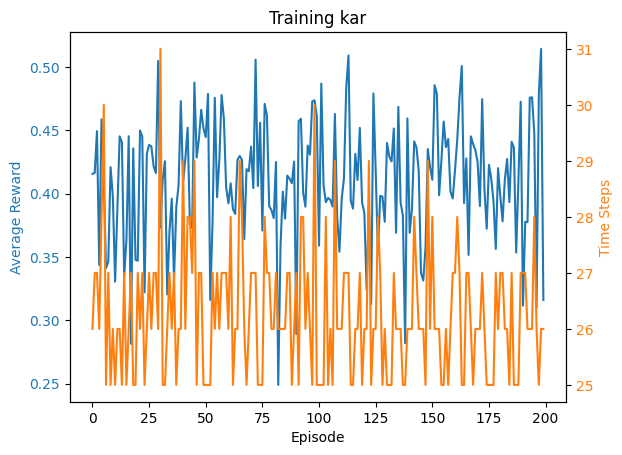

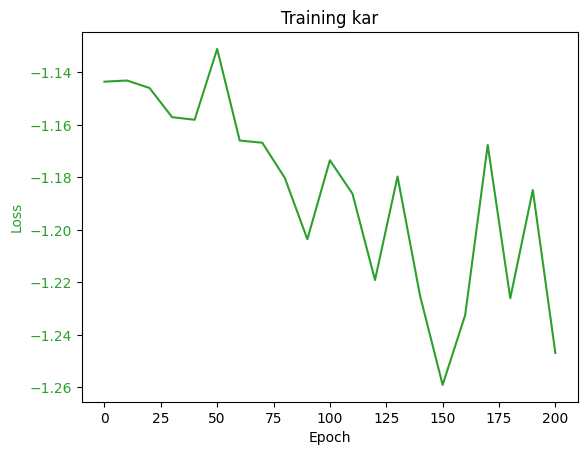

In [16]:
print("*"*20, "Setup Information", "*"*20)

# ° ------ Graph Setup ------ ° #
# ! Graph path (change the following line to change the graph)
graph_path = FilePaths.KAR.value
# Set the environment name as the graph name
env_name = graph_path.split("/")[-1].split(".")[0]
# Load the graph from the dataset folder
graph = Utils.import_mtx_graph(graph_path)
# Print the number of nodes and edges
print("* Graph Name:", env_name)
print("*", graph)

# ° --- Environment Setup --- ° #
# ! Define the detection algorithm to use (change the following line to change the algorithm)
detection_alg = DetectionAlgorithms.WALK.value
# Apply the community detection algorithm on the graph
dct = DetectionAlgorithm(detection_alg)
community_structure = dct.compute_community(graph)
# Choose one of the communities found by the algorithm, for now we choose the first one
community_target = community_structure[0]
print("* Community Detection Algorithm:", detection_alg)
print("* Community Target:", community_target)
# Define beta, i.e. the percentage of edges to add/remove
beta = HyperParams.BETA.value
# Define the environment
env = GraphEnvironment(beta=beta, debug=False)
# Setup the environment
env.setup(
    graph=graph,
    community=community_target,
    training=True,
    community_detection_algorithm=detection_alg)
# Get list of possible actions which can be performed on the graph by the agent
possible_actions = env.get_possible_actions(graph, community_target)
n_actions = len(possible_actions["ADD"]) + len(possible_actions["REMOVE"])
print("* Number of possible actions:", n_actions)

# ° ------ Agent Setup ------ ° #
# Dimensions of the state
state_dim = HyperParams.G_IN_SIZE.value
# Number of possible actions
action_dim = n_actions
# Standard deviation for the action
action_std = HyperParams.ACTION_STD.value
# Learning rate
lr = HyperParams.LR.value
# Gamma parameter
gamma = HyperParams.GAMMA.value
# Number of epochs when updating the policy
k_epochs = HyperParams.K_EPOCHS.value
# Value for clipping the loss function
eps_clip = HyperParams.EPS_CLIP.value
# Define the agent
agent = Agent(
    state_dim=state_dim,
    action_dim=action_dim,
    action_std=action_std,
    lr=lr,
    gamma=gamma,
    K_epochs=k_epochs,
    eps_clip=eps_clip)
# Define Memory
memory = Memory()
# Print Hyperparameters
print("*", "-"*18, "Hyperparameters", "-"*18)
print("* State dimension: ", state_dim)
print("* Action dimension: ", action_dim)
print("* Action standard deviation: ", action_std)
print("* Learning rate: ", lr)
print("* Gamma parameter: ", gamma)
print("* Number of epochs when updating the policy: ", k_epochs)
print("* Value for clipping the loss function: ", eps_clip)
print("*", "-"*53)

# Set random seed
# random_seed = HyperParams.RANDOM_SEED.value
# if random_seed:
#     print("* Random Seed: {}".format(random_seed))
#     torch.manual_seed(random_seed)
#     env.seed(random_seed)
#     np.random.seed(random_seed)
print("*"*20, "End Information", "*"*20, "\n")

# ° ------ Model Training ------ ° #
# Set the maximum number of steps per episode to the double of the edge budget
max_timesteps = env.edge_budget*2
# Set the update timestep to 10 times then edge budget
update_timesteps = env.edge_budget*10
# Start training
agent.train(
    env=env,
    memory=memory,
    max_timesteps=max_timesteps,
    update_timesteps=update_timesteps,
    env_name=env_name,
    detection_alg=detection_alg)